In [1]:
!pip install imbalanced-learn xgboost



[notice] A new release of pip is available: 25.0 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import pandas as pd
from sklearn.model_selection import RepeatedStratifiedKFold, GridSearchCV, cross_validate
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt

# Load dataset
df = pd.read_csv("fraud_detection_train.csv")  # Pastikan file berada di direktori kerja
X = df.drop(columns=['label', 'visit_id'])
y = df['label']

# Encode fitur kategorikal
for col in X.select_dtypes(include='object').columns:
    X[col] = LabelEncoder().fit_transform(X[col].astype(str))


In [3]:
# Scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Feature Selection
X_selected = SelectKBest(score_func=f_classif, k=30).fit_transform(X_scaled, y)

# SMOTE Balancing
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_selected, y)


C:\Python\Python312\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:112: UserWarning: Features [20 29 50] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
C:\Python\Python312\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


In [19]:
# Tuning Logistic Regression
param_grid = {
    'C': [0.001, 0.01, 1, 10],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear', 'lbfgs']
}

cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=2, random_state=42)
grid = GridSearchCV(LogisticRegression(max_iter=1000000000), param_grid, cv=cv, scoring='f1', n_jobs=-1)
grid.fit(X_resampled, y_resampled)

best_model = grid.best_estimator_
print("Best Parameters:", grid.best_params_)


C:\Python\Python312\Lib\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
40 fits failed out of a total of 160.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
40 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Python\Python312\Lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Python\Python312\Lib\site-packages\sklearn\base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py", line 1194, in fit
    solver = _check_solver(self.s

Best Parameters: {'C': 0.01, 'penalty': 'l1', 'solver': 'liblinear'}


In [22]:
scoring = ['precision', 'recall', 'f1', 'accuracy']
final_score = cross_validate(best_model, X_resampled, y_resampled,
                             scoring=scoring, cv=cv, n_jobs=-1)

results = pd.DataFrame({
    'Precision': final_score['test_precision'],
    'Recall': final_score['test_recall'],
    'F1-Score': final_score['test_f1'],
    'Accuracy': final_score['test_accuracy']
})
results.loc['Rata-rata'] = results.mean()
results


,Precision,Recall,F1-Score,Accuracy
0,0.554175,0.569348,0.561659,0.555658
1,0.553720,0.561618,0.557641,0.554486
2,0.556301,0.566206,0.561210,0.557304
3,0.551475,0.558626,0.555027,0.552142
4,0.553644,0.561817,0.557701,0.554436
5,0.553925,0.568401,0.561069,0.555334
6,0.554906,0.558227,0.556561,0.555234
7,0.554817,0.570395,0.562498,0.556356
8,0.554492,0.560271,0.557366,0.555060
9,0.553120,0.560072,0.556574,0.553788


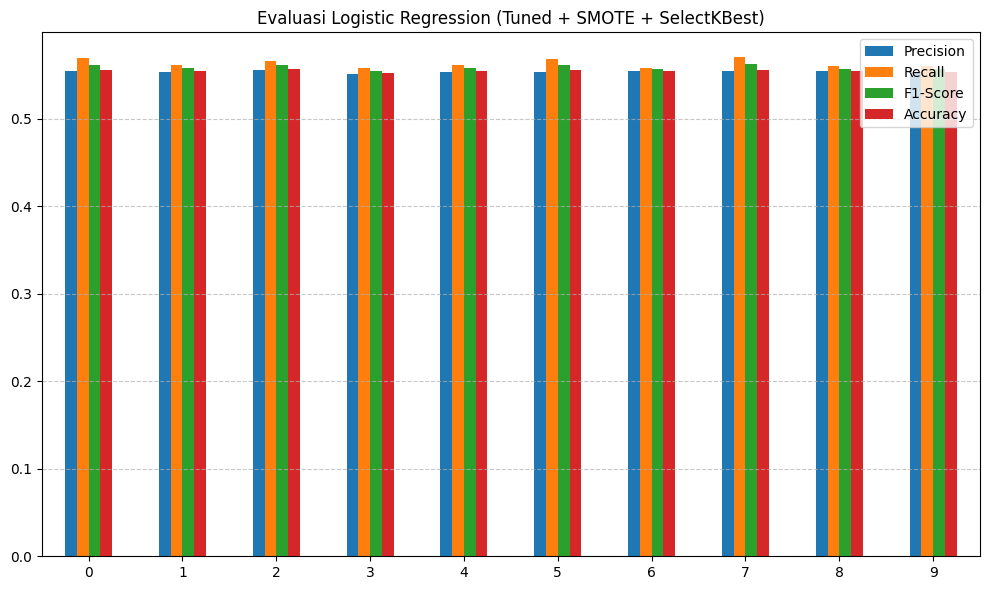

In [21]:
results.iloc[:-1].plot(kind='bar', figsize=(10, 6), title="Evaluasi Logistic Regression (Tuned + SMOTE + SelectKBest)")
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()
